In [10]:
# Import necessary libraries and modules
import sys
import numpy as np
from scipy.interpolate import interp1d

# Append parent directory to system path
sys.path.append("./python/")
from functions import *


from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import concentration

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True


In [11]:
# set cosmology
cosmo = cosmology.setCosmology('planck18')
h=cosmo.h

# Note that colossus takes in all quantities in units of h. So density is in units h^2 * M_sun/kpc^3, radius in kpc/h,
# and mass in M_sun/h. This means that in units of h, rho will be larger, and r and M will be smaller. To do this, we
# actually have to divide our physical rhos by h^2, so that colossus gets it in units h^2 * M_sun/kpc^3 , and multiply rs and 
# our physical rs and mass by h to get rs in units kpc/h and mass in units M_sun/h.

m200_arr = np.logspace(8,11,20) # in units M_sun
c200_arr = concentration.concentration(m200_arr*h, '200c', 0.0, model = 'diemer19') # m200*h gives colossus mass in M_sun/h

# Mean
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c, z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr = np.array([p.par['rhos']*h*2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

# Low
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c*10**(-.3), z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr_low = np.array([p.par['rhos']*h*2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr_low = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

# Low
p_nfw_arr = np.array([profile_nfw.NFWProfile(M = m*h, c = c*10**(.3), z = 0, mdef = '200c') for m,c in zip(m200_arr,c200_arr)]) # mdef = '200c' is just telling it to use 
rhos_arr_high = np.array([p.par['rhos']*h*2 for p in p_nfw_arr]) # this rhos is now in units M_sun/kpc^3 as we've removed the h dependence
Vmax_arr_high = np.array([p.Vmax()[0] for p in p_nfw_arr]) # velocity is always in units km/s

some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution
some entries with sigma_hat>0.1, proceed with caution


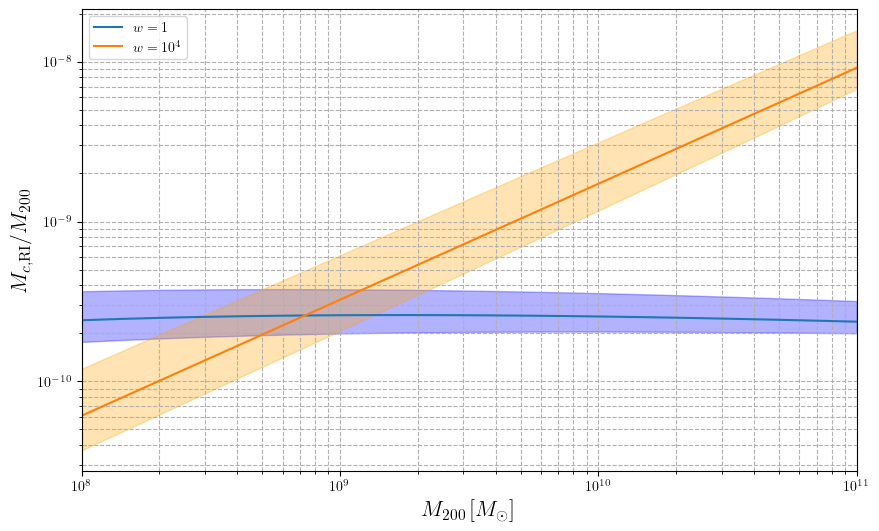

In [12]:
v_scale=20 #km/sec
sigma_over_m_scale=100
sigma_over_1=sigma_over_m_scale/K_5_int(v_scale/1)
sigma_over_1e4=sigma_over_m_scale/K_5_int(v_scale/1e4)


plt.figure(figsize=(10, 6))


# Mean lines
plt.loglog(m200_arr, M_c_RI(rhos_arr, Vmax_arr, 1, sigma_over_1) / m200_arr, label=r'$w=1$')
plt.loglog(m200_arr, M_c_RI(rhos_arr, Vmax_arr, 1e4, sigma_over_1e4) / m200_arr, label=r'$w=10^4$')

# Bands for w=1
plt.fill_between(m200_arr, 
                 M_c_RI(rhos_arr_low, Vmax_arr_low, 1, sigma_over_1) / m200_arr, 
                 M_c_RI(rhos_arr_high, Vmax_arr_high, 1, sigma_over_1) / m200_arr, 
                 color='blue', alpha=0.3)

# Bands for w=1e4
plt.fill_between(m200_arr, 
                 M_c_RI(rhos_arr_low, Vmax_arr_low, 1e4, sigma_over_1e4) / m200_arr, 
                 M_c_RI(rhos_arr_high, Vmax_arr_high, 1e4, sigma_over_1e4) / m200_arr, 
                 color='orange', alpha=0.3)

plt.xlabel(r'$M_{200} \, [M_{\odot}]$', fontsize=16)
plt.ylabel(r'${M_{c,\mathrm{RI}}}/{M_{200}}$', fontsize=16)

plt.legend(loc='upper left')
plt.xlim(1e8, 1e11)
plt.grid(True, which="both", ls="--")

plt.show()
